Data loading

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

file_name = 'cumulative_dataset'
file_name = 'windowed_180d_dataset'

data_path = f'/workspaces/msc_thesis/data/libraries/npm-libraries-1.6.0-2020-01-12/pull-requests/{file_name}.csv'
df = pd.read_csv(filepath_or_buffer=data_path, header=0)

train, test = train_test_split(df, test_size=0.2)

print(
    f'Training with {len(train)} entries, and testing with {len(test)} entries.')


Training with 1239324 entries, and testing with 309832 entries.


Downsamples the majority class to account for class imbalance.

In [2]:
class_counts = df['DepPRIsMerged'].value_counts()

print(f'{class_counts=}')
print(f'Class imbalance: {max(class_counts) / min(class_counts):.03f}.')

if False:
    from sklearn.utils import resample


    majority = df[df.DepPRIsMerged]
    minority = df[df.DepPRIsMerged == False]

    majority = resample(majority, replace=True,
                        n_samples=len(minority), random_state=0)

    df = pd.concat([majority, minority])

    print(f'Resampled size: {len(df)}.')

class_counts=DepPRIsMerged
True     1200819
False     348337
Name: count, dtype: int64
Class imbalance: 3.447.


Downsamples the dataset in case you set ``sample`` to ``>0``.

In [3]:
sample = -1
if sample > 0:
    train = train.sample(100000)
    print("WARNING: TRAINING WITH SAMPLE!")


Selects predictor features and the dependent feature.

In [4]:
print(f'{df.columns=}')

train_labels = train['DepPRIsMerged']
test_labels = test['DepPRIsMerged']

used_predictors = ['ContLifetime', 'ContHasComments',
                   'ContNumCommits', 'PRCountEco', 'PRAcceptanceRateEco']

print(f'{used_predictors=}')

train_predictors = train[used_predictors]
test_predictors = test[used_predictors]


df.columns=Index(['UUID', 'PR-Source', 'PR-ID', 'User-ID', 'DepPRIsMerged',
       'ContLifetime', 'ContHasComments', 'ContNumCommits',
       'ContDevSuccessRate', 'PRCountEco', 'PRAcceptanceRateEco'],
      dtype='object')
used_predictors=['ContLifetime', 'ContHasComments', 'ContNumCommits', 'PRCountEco', 'PRAcceptanceRateEco']


In [5]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
rf = RandomForestRegressor(100, random_state=0)

rf.fit(train_predictors, train_labels)

predictions = rf.predict(test_predictors)
predictions = [pred >= 0.5 for pred in predictions]

errors = abs(predictions ^ test_labels)

print(f'Absolute error: {errors}/{len(predictions)} ({errors / len(predictions)})')


conf = confusion_matrix(test_labels, predictions)
print(f'{conf=}')

f1 = f1_score(test_labels, predictions)
print(f'{f1=}')

print(classification_report(test_labels, predictions))


Absolute error: 491597      True
667051     False
358165      True
506149     False
422683     False
           ...  
735272     False
341199      True
1067499     True
690804     False
1335399     True
Name: DepPRIsMerged, Length: 309832, dtype: bool/309832 (491597     0.000003
667051     0.000000
358165     0.000003
506149     0.000000
422683     0.000000
             ...   
735272     0.000000
341199     0.000003
1067499    0.000003
690804     0.000000
1335399    0.000003
Name: DepPRIsMerged, Length: 309832, dtype: float64)
conf=array([[ 17920,  51498],
       [ 30968, 209446]])
f1=0.8355147419608343
              precision    recall  f1-score   support

       False       0.37      0.26      0.30     69418
        True       0.80      0.87      0.84    240414

    accuracy                           0.73    309832
   macro avg       0.58      0.56      0.57    309832
weighted avg       0.70      0.73      0.72    309832



Generates partial dependence plots.

It's visible that the intra-project experience completely overshadows other factors. 

When exclusing this, you can see that PR acceptance ratio matters as well as whether the PR has comments. 
Lifetime somehow has no effect whatsoever; ditto for the ecosystem PR count. 

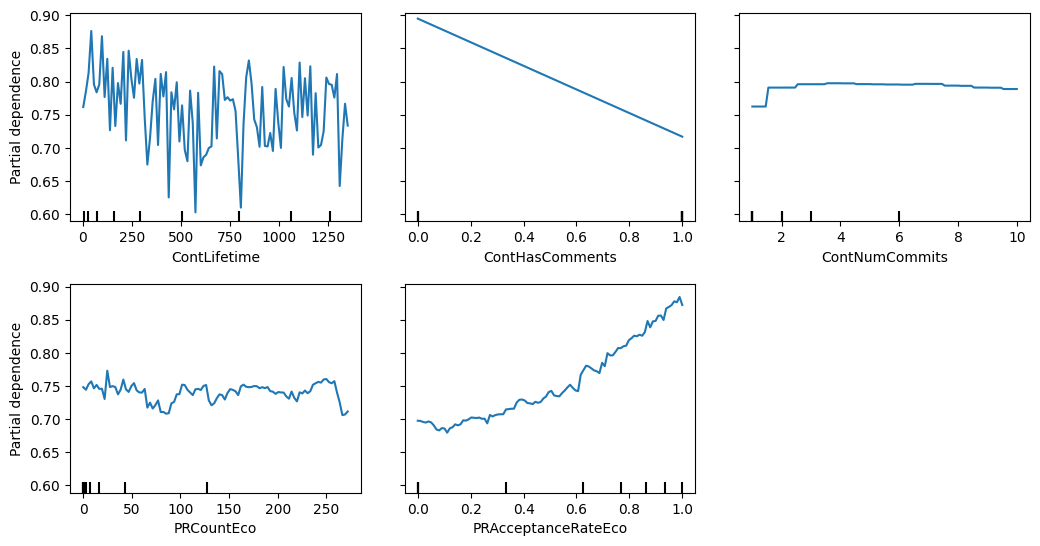

In [6]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

# Collective partial dependence plot.
PartialDependenceDisplay.from_estimator(rf, test_predictors, used_predictors)

fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(6)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.15,
                    hspace=0.3)


In [7]:
# Disabled as this takes forever.
# # Individual partial dependence plot.
# PartialDependenceDisplay.from_estimator(
#     rf, test_predictors, used_predictors, kind='individual')

# fig = plt.gcf()
# fig.set_figwidth(12)
# fig.set_figheight(6)
# fig.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.15,
#                     hspace=0.3)
